In [2]:
import h5py
import os
from IPython.display import display
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import importlib
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

import datasets
import models
import losses

In [3]:
importlib.reload(datasets)
filepath = 'datasets/nyu_depth/nyu_depth_v2_labeled.mat'
images, depths = datasets.nyu_depth(filepath, dsize=(224,224))
x_train, x_test, y_train, y_test = train_test_split(images, depths, test_size=0.2)

(480, 640, 3)
(480, 640)


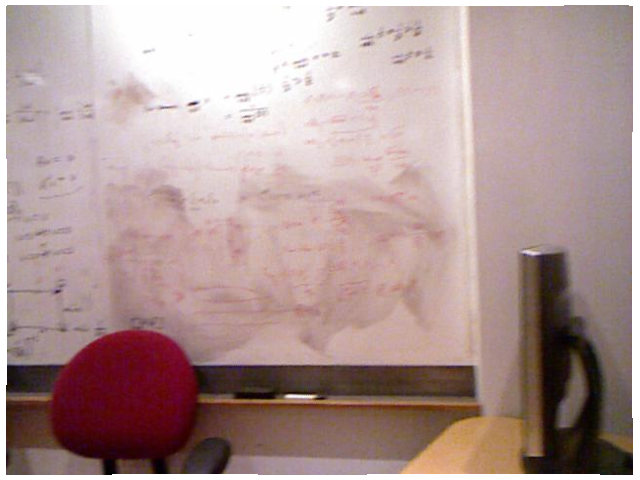

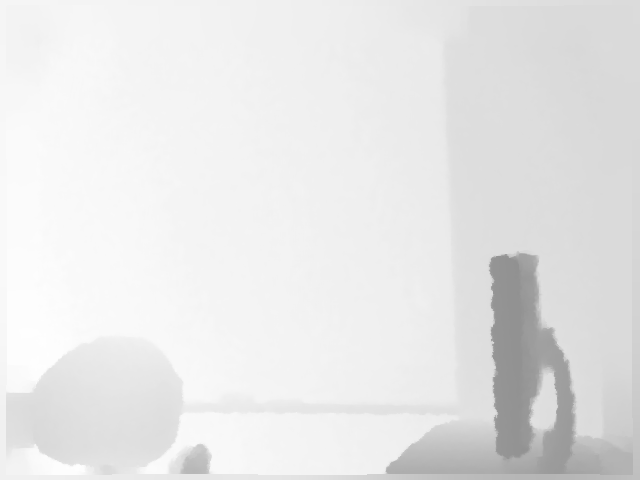

In [13]:
image_arr = images[32]
print(image_arr.shape)
depth_arr = depths[32]
print(depth_arr.shape)
depth_arr = (depth_arr/np.max(depth_arr) * 255).astype(np.uint8)
image = Image.fromarray(image_arr)
depth = Image.fromarray(depth_arr, "L")
display(image, depth)

In [4]:
importlib.reload(models)
importlib.reload(losses)
# (model, optimizer, loss, metrics) = models.vgg_segmentation(320, 224, 3, upsample=True)
# model = models.unet(224, 224, 3)
model = models.mobilenet_unet(224, 224, 3)
# loss = tf.keras.losses.MeanSquaredError()
# loss = tf.keras.losses.MeanAbsoluteError()
loss = losses.l1_ssim_edge
# loss = losses.edge_loss
metrics = tf.keras.metrics.CosineSimilarity()
optimizer = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
# optimizer = keras.optimizers.Adam(learning_rate=1e-2)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.save("depth_model.h5", include_optimizer=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

/home/amos/.local/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [5]:
batch_size = 5
epochs = 20
history = model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test))


Epoch 1/20
232/232 [==============================] - 55s 212ms/step - loss: 0.1159 - cosine_similarity: 0.9463 - val_loss: 0.1020 - val_cosine_similarity: 0.9637
Epoch 2/20
232/232 [==============================] - 47s 202ms/step - loss: 0.0913 - cosine_similarity: 0.9643 - val_loss: 0.0884 - val_cosine_similarity: 0.9678
Epoch 3/20
232/232 [==============================] - 47s 203ms/step - loss: 0.0855 - cosine_similarity: 0.9681 - val_loss: 0.0875 - val_cosine_similarity: 0.9699
Epoch 4/20
232/232 [==============================] - 47s 203ms/step - loss: 0.0817 - cosine_similarity: 0.9705 - val_loss: 0.0842 - val_cosine_similarity: 0.9685
Epoch 5/20
232/232 [==============================] - 55s 239ms/step - loss: 0.0795 - cosine_similarity: 0.9721 - val_loss: 0.0812 - val_cosine_similarity: 0.9722
Epoch 6/20
232/232 [==============================] - 70s 303ms/step - loss: 0.0772 - cosine_similarity: 0.9734 - val_loss: 0.0756 - val_cosine_similarity: 0.9728
Epoch 7/20
232/232 [==

(290, 224, 224)


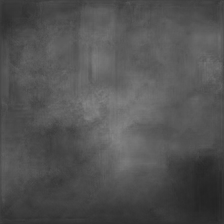

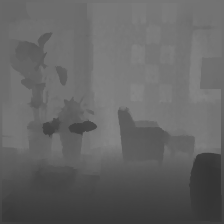

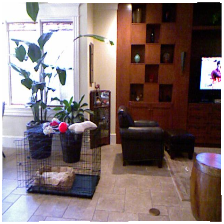

In [9]:
index = 80
img = (x_test[index] * 255).astype(np.uint8)
img = Image.fromarray(img)


out = model.predict(x_test[index:index+1, :, :, :])
out = Image.fromarray((out * 255).astype(np.uint8)[0, :, :, 0])

print(y_test.shape)
gt = Image.fromarray((y_test[index, :, :] * 255).astype(np.uint8))
display(out, gt, img)

# f, axarr = plt.subplots(3,1)
# axarr[0,0].imshow(out[0, :, :, 0])
# axarr[1,0].imshow(y_test[index, :, :])
# axarr[2,0].imshow(y_test[index, :, :])
# plt.show()

In [35]:
print(images_a[0][0].shape)
resized = cv2.resize(images[0][0], dsize=(240, 320))
print(resized.shape)

(480, 640, 3)


error: OpenCV(3.4.14-dev) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = 23 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [37]:
database = h5py.File(filepath)


(240, 320, 3)


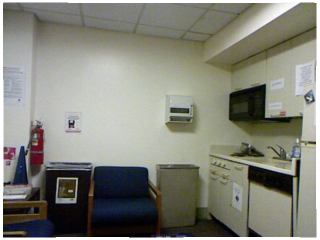

In [44]:
image = database['images'][0]
image = np.transpose(image)
image = cv2.resize(image, dsize=(320, 240))
print(image.shape)
img = Image.fromarray(image)
display(img)

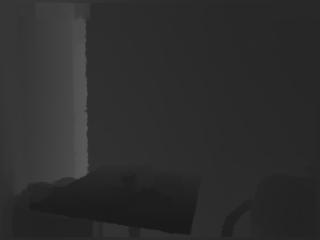

(1449, 240, 320)


In [5]:
img = Image.fromarray((depths[2]*255).astype(np.uint8))
display(img)
print(depths.shape)

In [24]:
image_bytes = tf.io.read_file('test.png')
image = tf.image.decode_image(image_bytes)
image = tf.cast(image, tf.float32)
image = tf.expand_dims(image, 0)
# sobel = tf.image.sobel_edges(image)
# sobel_y = np.asarray(sobel[0, :, :, :, 0]) # sobel in y-direction
# sobel_x = np.asarray(sobel[0, :, :, :, 1]) # sobel in x-direction
# Image.fromarray(sobel_y[..., 0] / 4 + 0.5).show()
# Image.fromarray(sobel_x[..., 0] / 4 + 0.5).show()

ssim = tf.image.ssim_multiscale(image[:, :, :, 0:1]/255, image[:, :, :, 1:2]/255, 1.0)
print(ssim)
print(np.max(image))
# Image.fromarray(ssim[..., 0]).show()

tf.Tensor([0.9478167], shape=(1,), dtype=float32)
255.0
